# EECS 598 Lab 5: Learning to Walk in Minutes using RL on the GPU

![./media/lab5_poster](./media/lab5_poster.png)

This notebook is worth **80 points**. Questions and implementation are marked with relevent `#TODO(student)` markers.

Before starting the assignment, please put your name and UMID in the following format:

Firstname LASTNAME, #00000000 (ex. Drew SCHEFFER #31415926)

**YOUR ANSWER**

SHIVAM UDESHI, 87841376

## Setup

In [1]:
import sys, types, importlib

# Create a tiny fake 'imp' module exposing only 'reload'
_imp = types.ModuleType("imp")
_imp.reload = importlib.reload
sys.modules["imp"] = _imp

# load autoreload
%load_ext autoreload
%autoreload 2

In [2]:
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.8 MB/s eta 0:00:00


### Google Colab Setup

Next, we'll run a few fommands to set up the environment on Google Colab. If you are running this notebook locally you can skip this section

Run the following to mount this notebook to your Google Drive. Follow the link and sign into the Google account following the prompts. Use the same Google account that you used to store this notebook.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now update the path below to point to the folder in your Google Drive where you uploaded this notebook. If everything worked correctly you should see the following filenames: [`google_barkour_vb`, `custom_env.py`, `lab5_poster.png`, `pedipulate_env.py`]

In [5]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded lab5
# Example: If you create a 2025FA folder and put all the files under Lab5, then '2025FA/Lab5'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025FA/Lab5'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/CSE_598/lab5-RL-walking/lab5-RL-walking'
GOOGLE_DRIVE_PATH_LAB5 = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH_LAB5))

# Add to path and change directory for good measure
sys.path.append(GOOGLE_DRIVE_PATH_LAB5)
os.chdir(GOOGLE_DRIVE_PATH_LAB5)

['.DS_Store', 'google_barkour_vb', 'media', '__pycache__', 'custom_env.py', '05_lab_student.ipynb']


In [6]:
from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

## Mujoco Setup & Imports

In [7]:
!pip install "brax==0.12.1" "mujoco==3.3.0" "mujoco_mjx==3.3.0" "orbax-checkpoint==0.5.10" etils
!pip install noise
!pip install playground

#If you're running this locally, make sure to install cuda enabled jax via something like:
#!pip install "python -m pip install -U "jax[cuda12]==0.5.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 kB 21.9 MB/s eta 0:00:00
  Created wheel for pytinyrenderer: filename=pytinyrenderer-0.0.14-cp312-cp312-linux_x86_64

In [8]:
import os

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Checking that the installation succeeded:
Installation successful.


Ensure that the output of the following cell is `[CudaDevice(id=0)]`

In [9]:
import jax
print(jax.devices())

[CudaDevice(id=0)]


In [10]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model



from custom_env import GoogleBarkourEnv

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Registered Environment "barkour"


# Training The Barkour Quadruped to Walk
First, we'll train the robot to walk given a certain velocity tracking command for the base ($v_x, v_y, \omega_z$). Training this policy will involve several concepts covered in previous labs.

Let's start with doing some domain randomization (taken directly from `Lab04`)!

In [15]:
def domain_randomize(sys, rng):
    """Randomizes the mjx.Model."""
    @jax.vmap
    def rand(rng):
        _, key = jax.random.split(rng, 2)
        # friction
        friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
        friction = sys.geom_friction.at[:, 0].set(friction)
        # actuator
        _, key = jax.random.split(key, 2)
        gain_range = (-5, 5)
        param = jax.random.uniform(
            key, (1,), minval=gain_range[0], maxval=gain_range[1]
        ) + sys.actuator_gainprm[:, 0]
        gain = sys.actuator_gainprm.at[:, 0].set(param)
        bias = sys.actuator_biasprm.at[:, 1].set(-param)
        return friction, gain, bias

    friction, gain, bias = rand(rng)

    in_axes = jax.tree_util.tree_map(lambda x: None, sys)
    in_axes = in_axes.tree_replace({
        'geom_friction': 0,
        'actuator_gainprm': 0,
        'actuator_biasprm': 0,
    })

    sys = sys.tree_replace({
        'geom_friction': friction,
        'actuator_gainprm': gain,
        'actuator_biasprm': bias,
    })

    return sys, in_axes

Registered Environment "barkour"


### Load in the Custom Simulation Environment
Next, we'll load up this lab's custom locomotion environment implemented in `custom_env.py`. Recall that in the cell block below, the robot is setting a 12-dim constant action (representing 12 joint position offsets from a canonical "default standing pose").

In [16]:
env_name="barkour"
env = envs.get_environment(env_name)

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(50):
    ctrl = -0.1 * jp.ones(env.sys.nu)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

media.show_video(env.render(rollout), codec="h264", fps=1.0 / env.dt)


Take a close look at `custom_env.py`. It should look quite familiar to the environments you've experimented with in the past.

The custom environment class is responsible for setting up some major functions that the reinforcement learning (RL) policy will interact with.

Here's a non-exhaustive list of what the environment implementation does under the hood:
1. outlines how the **robot action space** is defined,
2. defines the interface for how a user of the policy can control the robot (i.e. by tracking reference velocities)
3. defines the **RL observation** (the information the RL policy will have access to at every control step)
4. defines under what conditions the simulation should be **terminated or truncated**
4. **specifies reward functions** that are tailored and tuned to a specific task (such as walking)
5. **steps the physics engine** forward in time, applying relevant forces and torques
6. handles some level of domain randomization and random perturbations/noise (through kicks, etc)

`TODO(student)`: After looking through `custom_env.py`, define the simulated robot's observation space in as much detail as possible. How big is each observation? What does it contain? How is it structured? **(10 points)**

**Answer Here**

The simulated robot's observation space is a 465-dimensional vector formed by stacking 15 consecutive frames, each of size 31. Each frame includes: the yaw rate about the torso's z-axis (1), the gravity vector projected into the torso frame (3), the velocity command consisting of target vx,vy,wz(3), joint angles relative to a default standing pose (12), and the previous action applied to the joints (12). This structure gives the policy access to both the robot's current kinematic state and recent history, which is important for learning stable locomotion.

`TODO(student):` In plain English, describe the conditions under which this environment (defined in `custom_env.py`) signals that the episode is over and needs to be reset. Specifically, explain the conditions that cause the simulation to *terminate*. **(10 points)**

**Answer Here**

In this environment, an episode ends (the simulation terminates) when the robot is no longer in a valid walking state. This happens under three conditions:
The torso flips over if the robots upright orientation relative to gravity goes negative (meaning it has fallen).

Joint limits are exceeded if any leg joint moves beyond its allowed lower or upper bound.

The torso height is too low if the body drops below 0.18 m above the ground, which indicates the robot has collapsed.

If any of these conditions are met, the environment signals termination and the episode resets.

If you're curious about where we define *truncation* conditions, that's typically done in the PPO implementation.

### implement the Tracking Rewards

`TODO(student):` Complete the relevant TODOs in `custom_env.py` related to implementing the central "command tracking"-related rewards. **(20 points)**

### RL Loop and Debugging
In this section, we'll investigate how to set up the RL pipeline with batched environments. For this, we'll use a popular vectorized [implementation of Proximal Policy Optimization](https://github.com/google/brax/tree/main/brax/training/agents/ppo) (PPO) implemented in the [BRAX](https://github.com/google/brax) library.

Just FYI, BRAX is actually its own physics engine, originally seperate from MJX, but is developed by the same people that developed MJX, so many of the boilerplate and environment abstractions are similar. In fact, the standard "physics engine backend" for BRAX is now MJX.

In [17]:
# We grab the PPO implementation from BRAX...
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks

# Create the directory to save checkpoints to...
ckpt_path = epath.Path('/tmp/quadrupred_joystick/ckpts')
ckpt_path.mkdir(parents=True, exist_ok=True)

`TODO(student):` Impliment the `progress_callback` function below. **(5 points)**

In [19]:
# TODO(student): Feel free to use the following for the progress_callback impl
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_rew, min_rew = 40, 0

def progress_callback(num_steps, metrics):
    '''
    This is a callback function used to record and display the agent's training progress

    num_steps:  number of environment steps
    metrics:    dictionary of metrics
    '''

    # TODO(student): Fill in this function to plot training progress (episode reward) as the policy is evaluated during training
    # Feel free to use matplotlib. The intention is to have a plot that updates in real-time so the user stays updated.
    # Please plot at least the mean reward and standard deviation (as error bars). See `media/example_training_progress.png` for an example.
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics['eval/episode_reward'])
    ydataerr.append(metrics['eval/episode_reward_std'])

    plt.clf()
    plt.errorbar(x_data, y_data, yerr=ydataerr, capsize=5)
    plt.xlabel('Number of Environment Steps')
    plt.ylabel('Episode Reward')
    plt.title('Training Progress')
    plt.ylim([min_rew, max_rew])
    plt.grid(True)
    plt.tight_layout()
    plt.pause(0.01)
    # Also please periodically fill in the "times" array using the wall clock time.
    # This can help discern JIT and training times.


def policy_params_fn(current_step, make_policy, params):
    '''
    This is a callback function used to save policy checkpoints during training
    '''
    orbax_checkpointer = ocp.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(params)
    path = ckpt_path / f'{current_step}'
    orbax_checkpointer.save(path, params, force=True, save_args=save_args)


`TODO(student):` Update the below to define the `make_networks_factory` variable and update the ppo.train() function to contain our custom PPO network, domain randomization, and checkpoint saving functions. **(5 points)**

For your reference, the implementation of the BRAX PPO training and relevant function arguments [are here](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py?#L193).

In [20]:
# TODO(student): Use the ppo_networks library to create a PPO network "factory" (a Python Callable that returns a policy network) with 4 MLP hidden layers of 128 units each
# Hint: you can use functools.partial to pass preemptive arguments to functions in ppo_networks library.
make_networks_factory = functools.partial(
    # TODO(student): fill this in
    ppo_networks.make_ppo_networks,
    policy_hidden_layer_sizes=(128, 128, 128, 128),
    value_hidden_layer_sizes=(128, 128, 128, 128)
)

# TODO(student): Update the below to set the
train_fn = functools.partial(
      ppo.train, num_timesteps=100_000_000, num_evals=10,
      reward_scaling=1, episode_length=1000,
      normalize_observations=True, # Quite important, but try without it!
      action_repeat=1, unroll_length=20, num_minibatches=32,
      num_updates_per_batch=4, discounting=0.97, learning_rate=3.0e-4,
      entropy_cost=1e-2,
      num_envs=8192, # Feel free to mess around with this.
      batch_size=256,
      seed=0,
      network_factory=make_networks_factory,
      randomization_fn=domain_randomize,
      progress_fn=progress_callback,
      policy_params_fn=policy_params_fn

      # TODO(student): Add in (4) additional arguments to include domain randomziation,
      # custom PPO network, checkpoint saving, and progress callback.
      )

Run the training function after setting all the parameters. This should take on the order of minutes, and if everything is implemented correctly, you should see the average reward approach ~35. Colab takes a while to run, roughly 20 minutes on a T4.

Note what `ppo.train()` returns

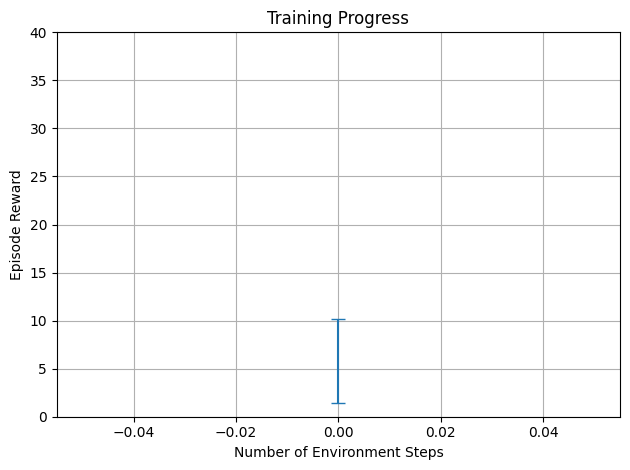

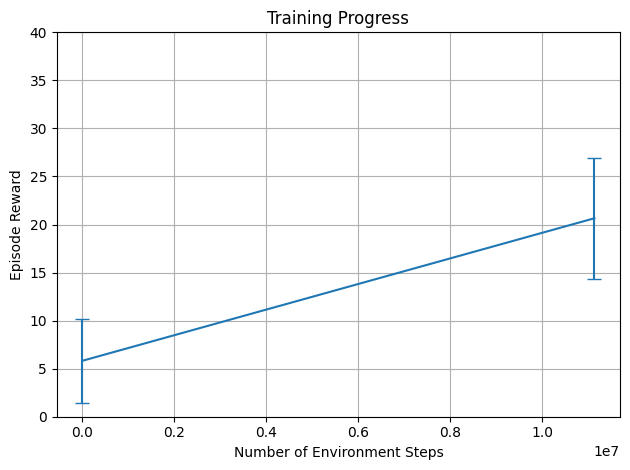

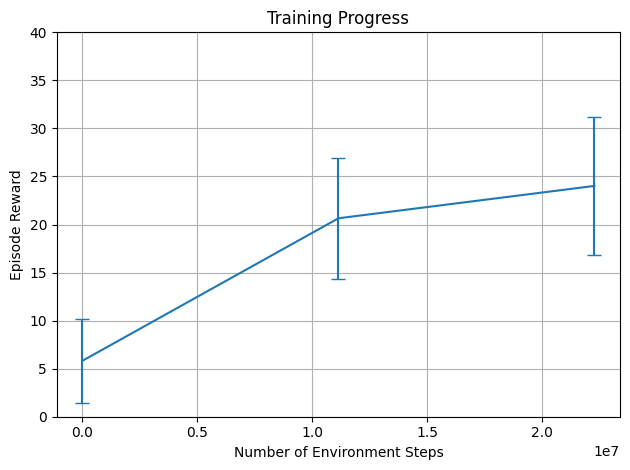

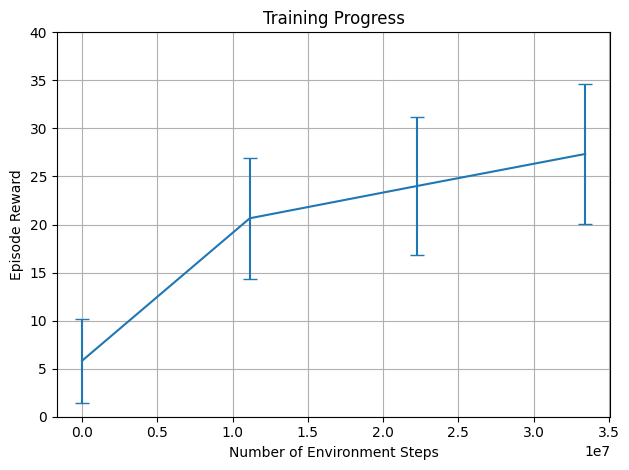

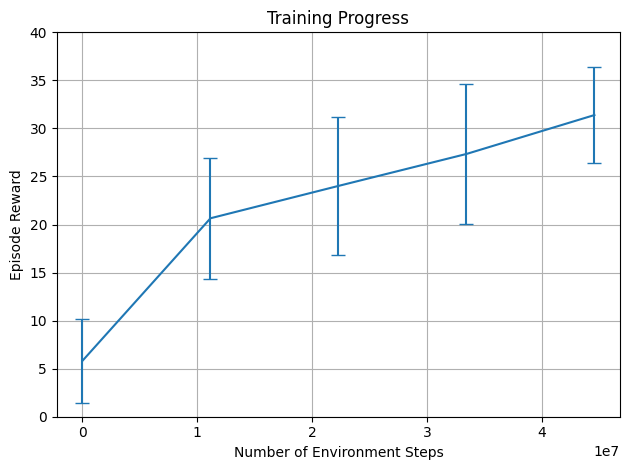

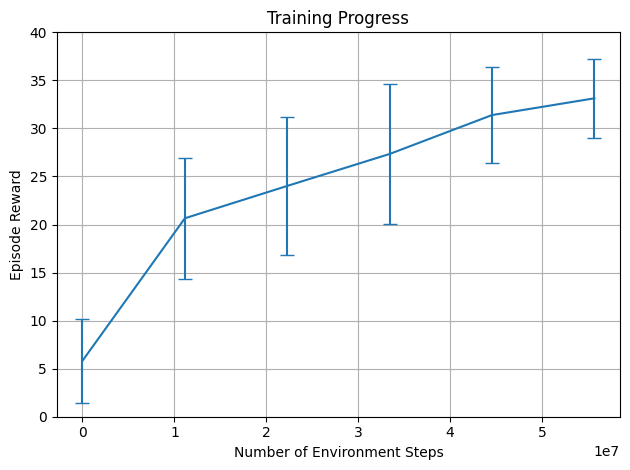

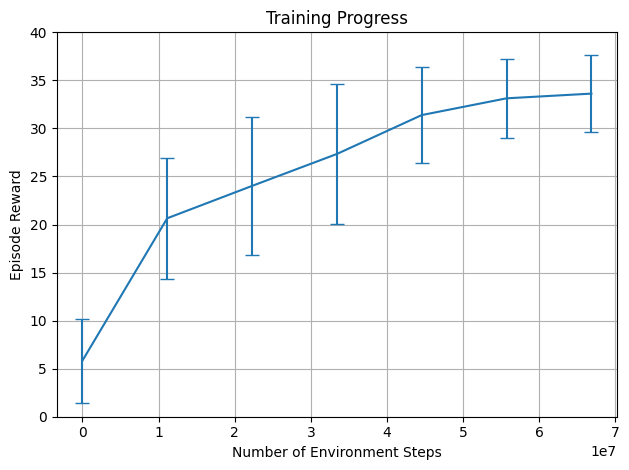

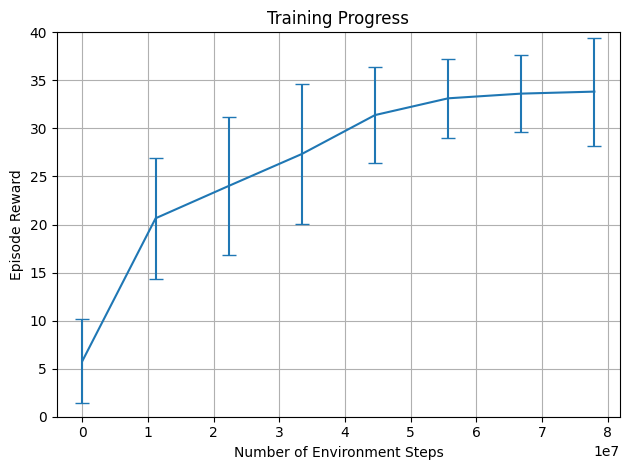

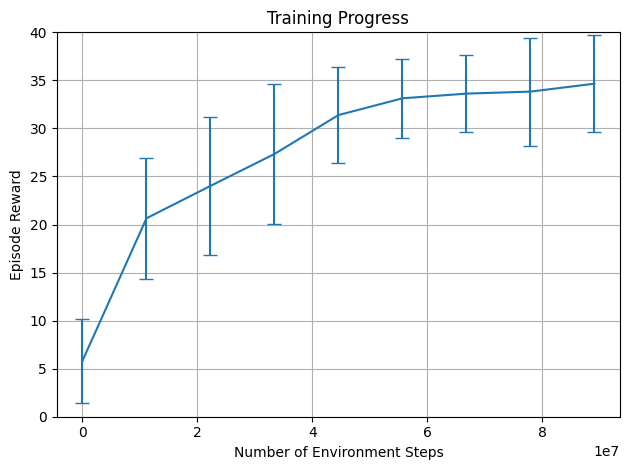

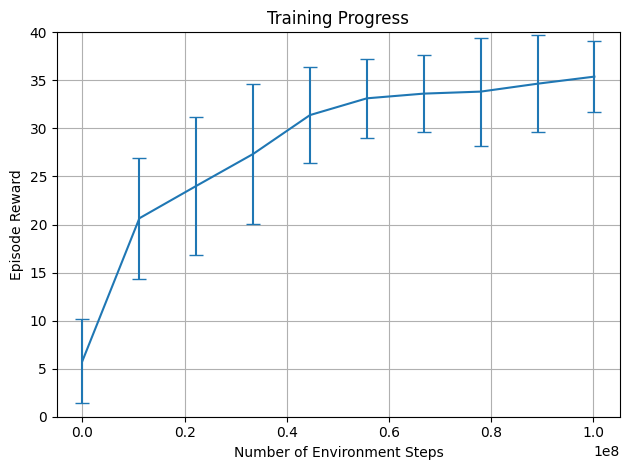

time to jit: 0:02:51.487018
time to train: 0:17:54.138236


In [21]:
# Reset environments since internals may be overwritten by tracers from the
# domain randomization function.
env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)
make_inference_fn, params, _= train_fn(environment=env,
                                       eval_env=eval_env)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
# If you you want to reload the make_inference_fn without training, you can use the following line:
# make_inference_fn, _, _= train_fn(environment=env,
#                                        num_timesteps=0,
#                                        eval_env=eval_env)

In [22]:
# Save and reload the final params.
model_path = '/tmp/mjx_brax_quadruped_policy'
model.save_params(model_path, params)
params = model.load_params(model_path)

### Visualize the Trained Policy
`TODO(student):` Visualize the trained policy. Make sure the policy accepts a command specified by the user. **(10 points)**

In [23]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

# TODO(student): Feel free to add anything here. Is there another function that you might want to jit?
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [24]:
# @markdown Commands **only used for Barkour Env**:
x_vel = 0.8  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
ang_vel = 0.0  #@param {type: "number"}

# grab a trajectory
n_steps = 500
render_every = 2

# TODO(student): Render a video of the trained policy controlling the robot to move around.
command = jp.array([x_vel, y_vel, ang_vel])

state = jit_reset(jax.random.PRNGKey(0))
state.info['command'] = command

rollout = []
rng = jax.random.PRNGKey(1)
for i in range(n_steps):
    rng, key = jax.random.split(rng)
    obs = state.obs
    # Unpack the tuple - we only need the action
    action, _ = jit_inference_fn(obs, key)
    state = jit_step(state, action)
    if i % render_every == 0:
        rollout.append(state.pipeline_state)

media.show_video(eval_env.render(rollout), fps=50)

# Let's Do Some Evaluation!


`TODO(student):` Time to do some evaluation of walking policy that was just learned. There are two deliverables that I would like you to produce:

1. First, make a **"gate plot"** that captures when each foot is in contact with the ground. This is a common way in robot locomotion to analyze the learned walking behavior. See `media/example_gate.png` for an example. **(10 points)**
2. Next, make plots that analyze how well the robot follows the $(v_x, v_y, \omega_z)$ tracking commands. **(10 points)**

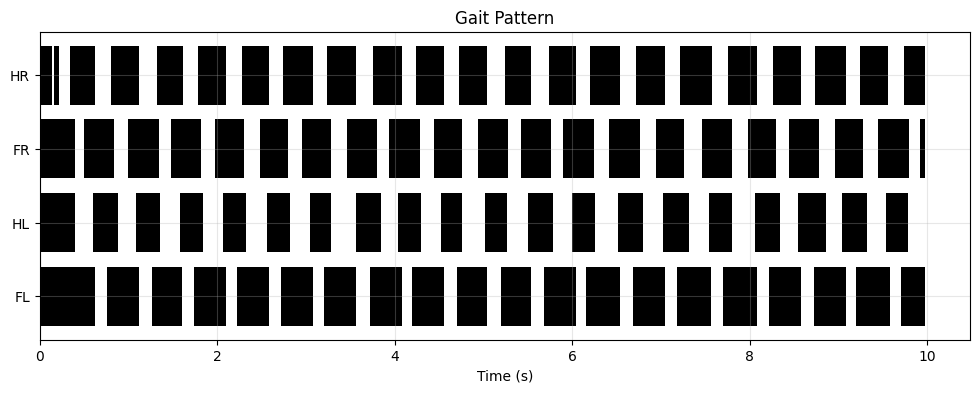

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# TODO(student): Impliment the plotting / analysis utilities here
foot_contacts = []
state = jit_reset(jax.random.PRNGKey(0))
state.info['command'] = jp.array([0.5, 0.0, 0.0])  # Set a forward velocity

rng = jax.random.PRNGKey(1)
for i in range(500):
    rng, key = jax.random.split(rng)
    obs = state.obs
    action, _ = jit_inference_fn(obs, key)  # Unpack tuple
    state = jit_step(state, action)

    # Get foot contacts
    foot_pos = state.pipeline_state.site_xpos[eval_env._feet_site_id]
    contact = (foot_pos[:, 2] - eval_env._foot_radius) < 1e-3
    foot_contacts.append(contact)

foot_contacts = np.array(foot_contacts)
time_steps = np.arange(len(foot_contacts)) * eval_env.dt

# Create gait plot
fig, ax = plt.subplots(figsize=(12, 4))
foot_names = ['FL', 'HL', 'FR', 'HR']

for i, name in enumerate(foot_names):
    contacts = foot_contacts[:, i]
    for j in range(len(contacts)-1):
        if contacts[j]:
            ax.barh(i, eval_env.dt, left=time_steps[j], height=0.8,
                   color='black', edgecolor='none')

ax.set_yticks(range(4))
ax.set_yticklabels(foot_names)
ax.set_xlabel('Time (s)')
ax.set_title('Gait Pattern')
ax.grid(True, alpha=0.3)
plt.show()

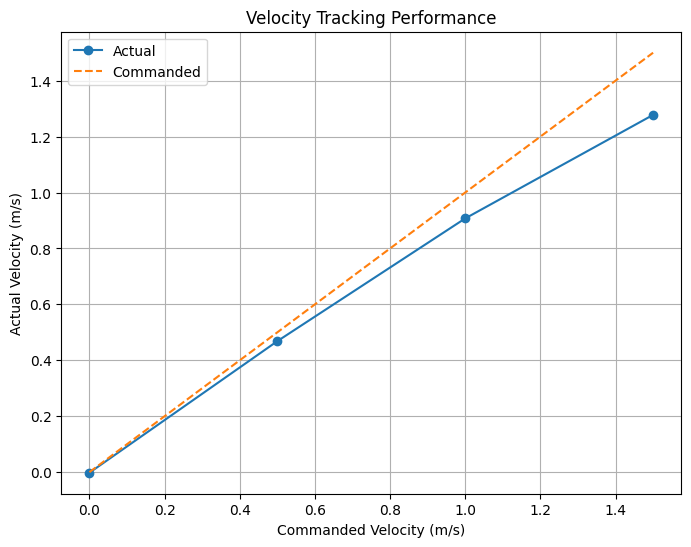

In [26]:
# Collect tracking data
commanded_vels = []
actual_vels = []

for cmd_vx in [0.0, 0.5, 1.0, 1.5]:
    state = jit_reset(jax.random.PRNGKey(0))
    state.info['command'] = jp.array([cmd_vx, 0.0, 0.0])

    vels = []
    rng = jax.random.PRNGKey(1)
    for i in range(200):  # Let it stabilize
        rng, key = jax.random.split(rng)
        action, _ = jit_inference_fn(state.obs, key)  # Unpack tuple
        state = jit_step(state, action)

        # Get body velocity
        inv_quat = math.quat_inv(state.pipeline_state.x.rot[0])
        body_vel = math.rotate(state.pipeline_state.xd.vel[0], inv_quat)
        vels.append(body_vel[0])

    commanded_vels.append(cmd_vx)
    actual_vels.append(np.mean(vels[-50:]))  # Average last 50 steps

plt.figure(figsize=(8, 6))
plt.plot(commanded_vels, actual_vels, 'o-', label='Actual')
plt.plot(commanded_vels, commanded_vels, '--', label='Commanded')
plt.xlabel('Commanded Velocity (m/s)')
plt.ylabel('Actual Velocity (m/s)')
plt.title('Velocity Tracking Performance')
plt.legend()
plt.grid(True)
plt.show()

`TODO(student):` How does the error change as the commanded velocity changes? Have the robot start off from rest, then progressively increase the $v_x$ tracking command. Does the robot consistently follow the speed? What's its "speed limit?" **(10 points)**

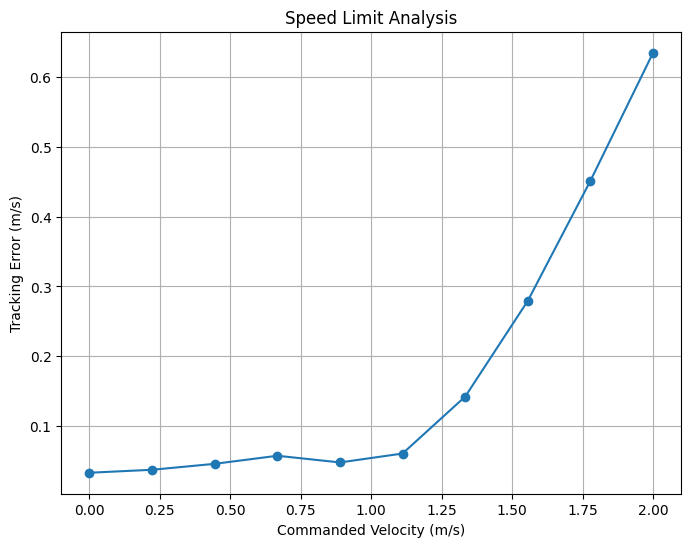

Robot can reliably track up to 1.33 m/s


In [27]:
# TODO(student): implement here
# Test increasing velocities
velocities = np.linspace(0, 2.0, 10)
tracking_errors = []

for v in velocities:
    state = jit_reset(jax.random.PRNGKey(0))
    state.info['command'] = jp.array([v, 0.0, 0.0])

    errors = []
    rng = jax.random.PRNGKey(1)
    for i in range(300):
        rng, key = jax.random.split(rng)
        action, _ = jit_inference_fn(state.obs, key)  # Unpack tuple
        state = jit_step(state, action)

        if i > 100:  # After stabilization
            inv_quat = math.quat_inv(state.pipeline_state.x.rot[0])
            body_vel = math.rotate(state.pipeline_state.xd.vel[0], inv_quat)
            errors.append(abs(v - body_vel[0]))

    tracking_errors.append(np.mean(errors))

plt.figure(figsize=(8, 6))
plt.plot(velocities, tracking_errors, 'o-')
plt.xlabel('Commanded Velocity (m/s)')
plt.ylabel('Tracking Error (m/s)')
plt.title('Speed Limit Analysis')
plt.grid(True)
plt.show()

# Find speed limit
speed_limit_idx = np.where(np.array(tracking_errors) > 0.2)[0]
if len(speed_limit_idx) > 0:
    print(f"Robot can reliably track up to {velocities[speed_limit_idx[0]-1]:.2f} m/s")
else:
    print(f"Robot can track all tested velocities up to {velocities[-1]:.2f} m/s")

### Test on an Out-of-Distribution (OOD) Environment
Let's see how the robot fares on an out of distribution environment. Specifically, we'll expose it to a non-flat terrain using a perlin noise height field.
The non-flat terrain has already been defined in `google_barkour/scene_hfield_mjx.xml`. If you're curious, the height field image it uses is `google_barkour/heigh_field.png`.

If you're interested feel free to make your own custom terrains using the code form last lab!

`TODO(student):` Set up the environment to use the non-flat scene definition and render a video of your trained walking policy on the novel environment. What do you notice? **(10 points)**

**Answer Here**

The policy isn't quite robust to uneven or rough terrains. We can clearly see the robot struggle to walk or loose balance repeatedly.

In [28]:
# use the height field scene
scene_file = 'scene_hfield_mjx.xml'

# TODO(student): implement here
eval_env_hfield = envs.get_environment(env_name, scene_file='scene_hfield_mjx.xml')

jit_reset_hfield = jax.jit(eval_env_hfield.reset)
jit_step_hfield = jax.jit(eval_env_hfield.step)

state = jit_reset_hfield(jax.random.PRNGKey(0))
state.info['command'] = jp.array([0.5, 0.0, 0.0])

rollout = []
rng = jax.random.PRNGKey(1)
for i in range(500):
    rng, key = jax.random.split(rng)
    action, _ = jit_inference_fn(state.obs, key)  # Unpack tuple
    state = jit_step_hfield(state, action)
    if i % 2 == 0:
        rollout.append(state.pipeline_state)

media.show_video(eval_env_hfield.render(rollout), fps=50)

### Finetune Your Policy on the OOD Environment
the BRAX `ppo.train` provides a way to continue from a previous checkpoint. This finetuning procedure may mean you don't have to train for as many steps.

`TODO(student):` Finetune the policy you trained on the non-flat terrain. Plotting the reward during finetuning. **(10 points)**

Hint: check out the argument "restore_checkpoint_path" from ppo.train()

Loading checkpoint from: /tmp/quadrupred_joystick/ckpts/100270080
Starting finetuning on rough terrain...


/usr/local/lib/python3.12/dist-packages/orbax/checkpoint/type_handlers.py:1475: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


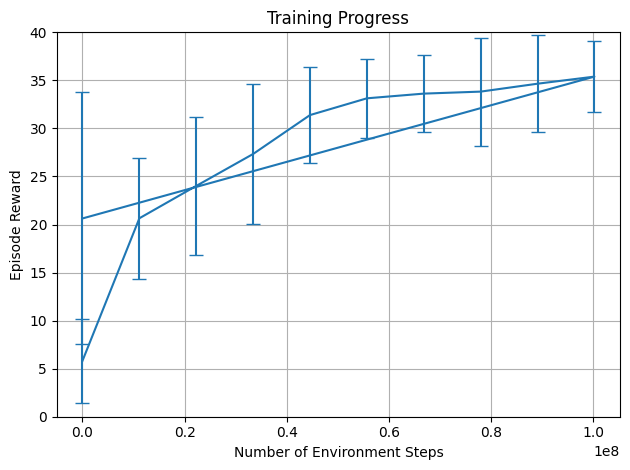

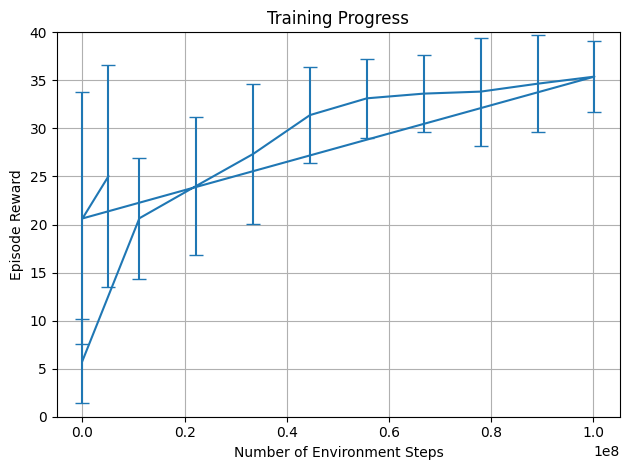

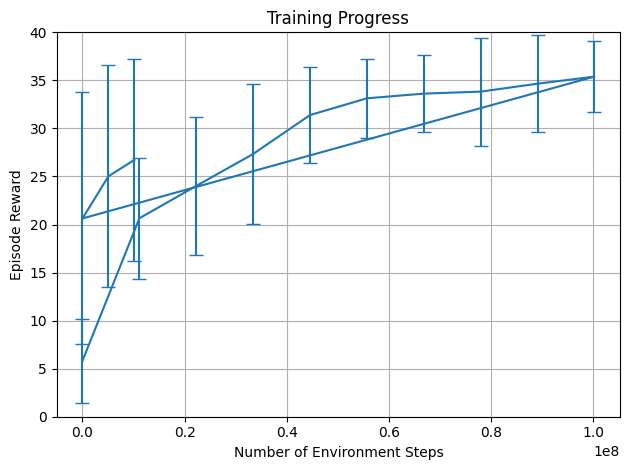

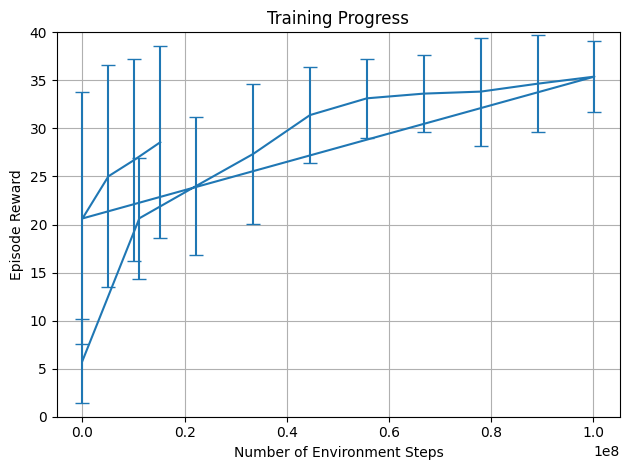

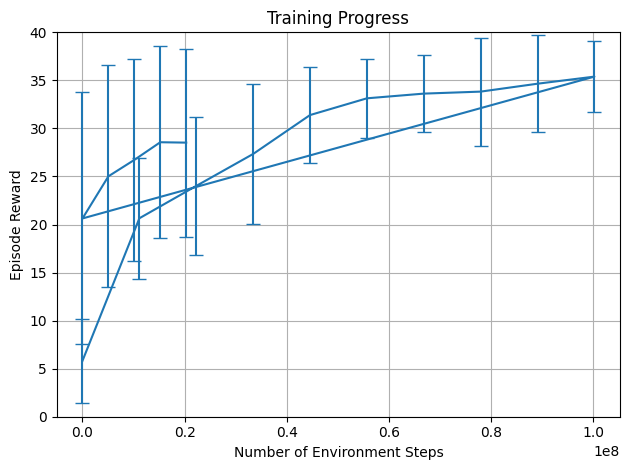

Finetuning complete!
Time to finetune: 0:36:08.113183


In [29]:
# grab the latest checkpoint from the flat terrain joystick policy
latest_ckpts = list(ckpt_path.glob('*'))
latest_ckpts.sort(key=lambda x: int(x.as_posix().split('/')[-1]))

latest_checkpoint = latest_ckpts[-1]

print(f"Loading checkpoint from: {latest_checkpoint}")

# Create finetuning training function
finetune_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000,  # Fewer timesteps needed for finetuning
    num_evals=5,
    restore_checkpoint_path=latest_checkpoint,  # Load previous checkpoint
    reward_scaling=1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=1e-4,  # Lower learning rate for finetuning
    entropy_cost=1e-2,
    num_envs=4096,  # Can use fewer envs for finetuning
    batch_size=256,
    seed=1,
    network_factory=make_networks_factory,
    randomization_fn=domain_randomize,
    progress_fn=progress_callback,
)

# Create environments with heightfield terrain
env_hfield = envs.get_environment(env_name, scene_file='scene_hfield_mjx.xml')
eval_env_hfield = envs.get_environment(env_name, scene_file='scene_hfield_mjx.xml')

# Run finetuning
print("Starting finetuning on rough terrain...")
make_inference_fn_finetuned, params_finetuned, _ = finetune_fn(
    environment=env_hfield,
    eval_env=eval_env_hfield
)

print(f'Finetuning complete!')
print(f'Time to finetune: {times[-1] - times[0]}')

# Save finetuned params
model_path_finetuned = '/tmp/mjx_brax_quadruped_policy_finetuned'
model.save_params(model_path_finetuned, params_finetuned)


### Evaluate the Finetuned policy

`TODO(student):` Compare the original flat-terrain policy to the finetuned policy in some way. This can be via a video, or plot. Explain the difference you observe below **(10 points)**

**Answer Here**


The original flat-terrain policy had to learn locomotion entirely from scratch, starting with low rewards and requiring many environment steps to improve. In contrast, the finetuned policy began with much higher rewards since it transferred prior knowledge of walking from flat terrain. This allowed it to adapt more quickly to the rough terrain, achieving good performance with fewer training steps. Overall, finetuning proved more sample-efficient and effective for handling the out-of-distribution environment.

## What to Turn In

`#TODO(student):` Please zip the following files and turn them into the assignment on gradescope:
1. this `05_lab_student.ipynb` file. Please make sure to fill our your name and umich ID in the first cell
2. the modified `custom_env.py` file.